In [5]:
!pip install ultralytics opencv-python

In [6]:
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from google.colab import files

In [7]:
# Load YOLOv8 Large model pretrained on COCO
model = YOLO("yolov8l.pt")

# -------- Step 2: Upload an Image --------
print("📤 Please upload a road scene image...")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

frame = cv2.imread(image_path)
if frame is None:
    raise Exception("❌ Image not found! Check your upload.")


📤 Please upload a road scene image...


Saving road.jpg to road (1).jpg


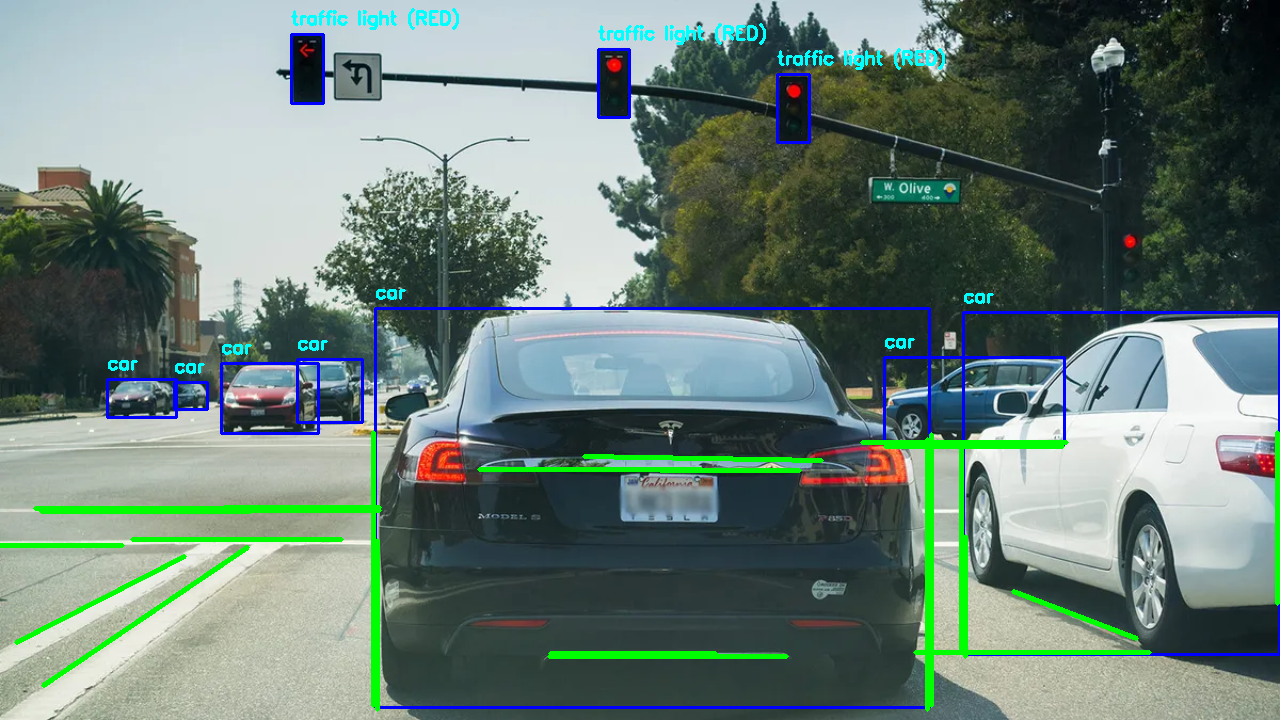

In [8]:
# Resize for faster inference (optional)
frame = cv2.resize(frame, (1280, 720))

# -------- Step 3: Lane Detection Function --------
def detect_lane(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # Detect edges
    edges = cv2.Canny(blur, 100, 200)

    # Mask region of interest (lower 40% of frame)
    mask = np.zeros_like(edges)
    h, w = edges.shape
    polygon = np.array([[
        (0, h),
        (w, h),
        (w, int(h*0.6)),
        (0, int(h*0.6))
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    cropped = cv2.bitwise_and(edges, mask)

    # Hough transform for lane lines
    lines = cv2.HoughLinesP(
        cropped,
        1,
        np.pi/180,
        threshold=120,
        minLineLength=120,
        maxLineGap=30
    )

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

    return frame

# -------- Step 4: Traffic Light Color Detection Function --------
def detect_traffic_light_color(roi):
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Red (two ranges because red wraps around hue 0)
    red1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
    red2 = cv2.inRange(hsv, (160, 100, 100), (179, 255, 255))
    red = cv2.bitwise_or(red1, red2)

    # Yellow
    yellow = cv2.inRange(hsv, (15, 100, 100), (35, 255, 255))

    # Green
    green = cv2.inRange(hsv, (40, 50, 50), (90, 255, 255))

    counts = {
        "RED": cv2.countNonZero(red),
        "YELLOW": cv2.countNonZero(yellow),
        "GREEN": cv2.countNonZero(green)
    }

    color = max(counts, key=counts.get)
    if counts[color] < 50:  # ignore weak signals
        return "UNKNOWN"
    return color

# -------- Step 5: Object Detection with YOLOv8 --------
results = model.predict(source=frame, conf=0.6, iou=0.45, verbose=False)

for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        label = model.names[cls]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Draw bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        color_state = ""
        # If detected object is a traffic light → check its color
        if label == "traffic light":
            roi = frame[y1:y2, x1:x2]
            if roi.size != 0:
                color_state = detect_traffic_light_color(roi)

        # Add label text
        label_text = f"{label}"
        if color_state != "":
            label_text += f" ({color_state})"

        cv2.putText(frame, label_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

# -------- Step 6: Add Lane Lines --------
frame = detect_lane(frame)
cv2_imshow(frame)